# Evolutionary Computation - Assignment 4: Candidate moves

Bartosz Stachowiak 148259<br>
Andrzej Kajdasz 148273

## 1. Problem Statement

There are columns of integers representing nodes. Each row corresponds to a node and contains its x and y coordinates in a plane, as well as a cost associated with the node. There were 4 such data sets each consisting of 200 rows (each representing a single node).

Problem to solve is to choose precisely 50% of the nodes (rounding up if there is an odd number of nodes) and create a Hamiltonian cycle (a closed path) using this subset of nodes. The goal is to minimize the combined total length of the path and the total cost of the selected nodes.

To calculate the distances between nodes, the Euclidean distance formula was used and then round the results to the nearest integer. As suggested, the distances between the nodes were calculated after loading the data and placed in a matrix, so that during the subsequent evaluation of the problem, it was only necessary to read these values which reduced the cost of the operation of the algorithm.

To solve the problem the local search algorithm (steepest) with candidate moves was used. We operate in edge-intra and inter neighbourhood.

## 2. Pseudocode of all implemented algorithms

### Local Steepest Search with Candidates

```
function generate_candidate_operations(solution, nodes, distance_matrix, closest_nodes):
    UNVISITED = -1
    node_solution_index = [UNVISITED] * len(nodes)
    for i in range(len(solution)):
        node_solution_index[solution[i]] = i
    
    operations = []
    for i in range(len(solution)):
        i_successor = (i + 1) % len(solution)
        i_predecessor = (i - 1) % len(solution)
        for j in range(len(closest_nodes[i])):
            candidate = node_solution_index[closest_nodes[i][j]]
            candidate_solution_index = node_solution_index[candidate]
            
            candidate_not_in_solution = candidate_solution_index == UNVISITED

            if candidate_not_in_solution:
                operations.append(NodeReplaceOperation(i_successor, candidate))
                operations.append(NodeReplaceOperation(i_predecessor, candidate))
            else:
                candidate_predecessor = (candidate_solution_index - 1) % len(solution)
                operations.append(EdgeSwapOperation(i, candidate_solution_index))
                operations.append(EdgeSwapOperation(i_predecessor, candidate_predecessor))

    return operations

``` 


```
function local_steepest_candidate_search(solution, nodes, distance_matrix, num_candidates):
    closest_nodes = index_closest_nodes(nodes, distance_matrix, num_candidates)    
    while true:
        operations = generate_candidate_operations(solution, nodes, distance_matrix, closest_nodes)

        best_operation = None
        best_delta = 0
        for operation in operations:
            delta = op.evaluate_delta(solution, nodes, distance_matrix)
            if delta < best_delta:
                best_operation = operation
                best_delta = delta

        if best_operation is None:
            break
        solution = selected_operation.apply(solution)

    return solution
```

## 3. Results of the computational experiments

### 3.1. Code for visualization of the results

In [1]:
import pathlib
import itertools

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from common import *

In [2]:
DATA_FOLDER = '../data/'
OLD_RESULTS_FOLDER = f'{DATA_FOLDER}old_results/'
RESULT_FOLDER = f'{DATA_FOLDER}results/'
INSTANCE_FOLDER = f'{DATA_FOLDER}tsp_instances/'

SOLVERS = {
    "lsc-5-r" : "Steepest LS, with (5) Candidates",
    "lsc-10-r" : "Steepest LS, with (10) Candidates",
    "lsc-15-r" : "Steepest LS, with (15) Candidates",
    "lsc-20-r" : "Steepest LS, with (20) Candidates",
    "lsc-50-r" : "Steepest LS, with (50) Candidates",
}

OLD_SOLVERS = {
    'n': "Nearest Neighbor",
    'g': "Greedy Cycle",
    'd-1': "Greedy 2-regret heuristics",
    'd-1.25': "Weighted greedy heuristics (0.25)",
    'd-1.75': "Weighted greedy heuristics (0.75)",
    'r': "Random",
    'd': "Greedy Heuristic",
    'lssnode-r' : "Steepest LS, node neighborhood (random)",
    'lssedge-r' : "Steepest LS, edge neighborhood (random)",
    'lssboth-r' : "Steepest LS, both neighborhood (random)",
    'lsgnode-r' : "Greedy LS, node neighborhood (random)",
    'lsgedge-r' : "Greedy LS, edge neighborhood (random)",
    'lsgboth-r' : "Greedy LS, both neighborhood (random)",
    'lssnode-d' : "Steepest LS, node neighborhood (GH)",
    'lssedge-d' : "Steepest LS, edge neighborhood (GH)",
    'lssboth-d' : "Steepest LS, both neighborhood (GH)",
    'lsgnode-d' : "Greedy LS, node neighborhood (GH)",
    'lsgedge-d' : "Greedy LS, edge neighborhood (GH)",
    'lsgboth-d' : "Greedy LS, both neighborhood (GH)",
}
SOLVERS_TO_PLOT = SOLVERS.copy()
SOLVERS_TO_PLOT.update({"lssedge-r": OLD_SOLVERS["lssedge-r"]})
SOLVERS_NO_TIME = ["n","g","d-1","d-1.75","d-1.25"]
SOLVERS.update(OLD_SOLVERS)
NUM_NODES = 200

instance_files = [path for path in pathlib.Path(INSTANCE_FOLDER).iterdir() if path.is_file()]
instance_names = [path.name[:4] for path in instance_files]

In [3]:
instances_data = {
    name: read_instance(f'{INSTANCE_FOLDER}{name}.csv')
    for name in instance_names
}

In [4]:
instances_solvers_pairs = itertools.product(instances_data.keys(), SOLVERS.keys())

all_results = {}
all_costs = {}
all_times = {}
all_stats = {}

for instance, solver in instances_solvers_pairs:
    all_results[instance] = all_results.get(instance, {})
    all_costs[instance] = all_costs.get(instance, {})
    all_times[instance] = all_times.get(instance, {})
    all_stats[instance] = all_stats.get(instance, {})
    costs = []
    times = []
    paring_results = []
    for idx in range(NUM_NODES):
        if(solver in SOLVERS_NO_TIME):
            time = 0
            solution, cost = read_solution_timeless(f'{OLD_RESULTS_FOLDER}{instance}-{solver}-{idx}.txt')
        elif(solver in OLD_SOLVERS):
            solution, cost, time = read_solution(f'{OLD_RESULTS_FOLDER}{instance}-{solver}-{idx}.txt')
        else:
            solution, cost, time = read_solution(f'{RESULT_FOLDER}{instance}-{solver}-{idx}.txt')
        paring_results.append(solution)
        costs.append(cost)
        times.append(time)
    all_results[instance][solver] = np.array(paring_results)
    all_costs[instance][solver] = np.array(costs)
    all_stats[instance][solver] = {
        'mean': np.mean(costs),
        'std': np.std(costs),
        'min': np.min(costs),
        'max': np.max(costs),
    }
    all_times[instance][solver] = {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times),
    }

In [5]:
costs_df = pd.DataFrame(all_stats).T
time_df = pd.DataFrame(all_times).T
max_df = pd.DataFrame(all_stats).T
min_df = pd.DataFrame(all_stats).T
mean_time_df = pd.DataFrame(all_times).T

for column in SOLVERS.keys():
    costs_df[column] = costs_df[column].apply(lambda x: f'{x["mean"]:.0f} ({x["min"]:.0f} - {x["max"]:.0f})')
    time_df[column] = time_df[column].apply(lambda x: f'{x["mean"]/1000:.2f} ({x["min"]/1000:.2f} - {x["max"]/1000:.2f})')
    max_df[column] = max_df[column].apply(lambda x: x['max'])
    min_df[column] = min_df[column].apply(lambda x: x['min'])
    mean_time_df[column] = mean_time_df[column].apply(lambda x: x['mean']/1000)

for df in [costs_df, time_df, max_df, min_df, mean_time_df]:
    df.rename(columns=SOLVERS, inplace=True)
time_df = time_df.filter(items = SOLVERS_TO_PLOT.values())
mean_time_df = mean_time_df.filter(items  = SOLVERS_TO_PLOT.values())

### 3.2. Visualizations and statistics of cost for all dataset-algorithm pairs

In tabular form we present the Mean, Minimum and Maximum of the results of the algorithms for each dataset.

In [6]:
print("Mean (min-max) of the costs:")

best_means = {
    instance: min(all_stats[instance][solver]['mean'] for solver in SOLVERS.keys())
    for instance in instance_names
}

def apply_style(v: str, best_val: float):
    num = v.split()[0]
    try:
        num = float(num)
    except ValueError:
        return ""
    if round(num) == round(best_val):
        return "font-weight: bold; color: red"
    return ""
    


costs_df.T.style.apply(lambda x: [
    apply_style(v, best_means[x.index[i]])
    for i, v in enumerate(x)
], axis = 1)

Mean (min-max) of the costs:


,TSPA,TSPB,TSPC,TSPD
"Steepest LS, with (5) Candidates",87176 (81754 - 95375),80747 (75336 - 87897),52621 (48880 - 56368),49544 (46009 - 54518)
"Steepest LS, with (10) Candidates",80691 (76743 - 85722),74009 (70319 - 80274),51425 (49109 - 54045),48280 (45307 - 53126)
"Steepest LS, with (15) Candidates",78939 (75796 - 85320),72112 (68607 - 77784),51370 (48836 - 53971),48291 (45647 - 51777)
"Steepest LS, with (20) Candidates",78007 (74934 - 81591),71372 (68382 - 76351),51432 (48836 - 54057),48221 (45713 - 51499)
"Steepest LS, with (50) Candidates",77845 (75341 - 81983),71259 (68549 - 75439),51435 (49259 - 54659),48244 (45780 - 51678)
Nearest Neighbor,87679 (84471 - 95013),79283 (77448 - 82631),58873 (56304 - 63697),54291 (50335 - 59846)
Greedy Cycle,77064 (75666 - 80321),70735 (68743 - 76324),55842 (53226 - 58876),54838 (50409 - 60964)
Greedy 2-regret heuristics,116240 (104829 - 124764),118807 (109774 - 128550),69014 (65095 - 73090),70442 (64682 - 74903)
Weighted greedy heuristics (0.25),76266 (74756 - 80219),73285 (69492 - 78741),55214 (52915 - 58640),52063 (46816 - 56677)
Weighted greedy heuristics (0.75),77131 (75666 - 80015),70702 (68740 - 76841),56038 (53952 - 59146),54228 (50047 - 59441)


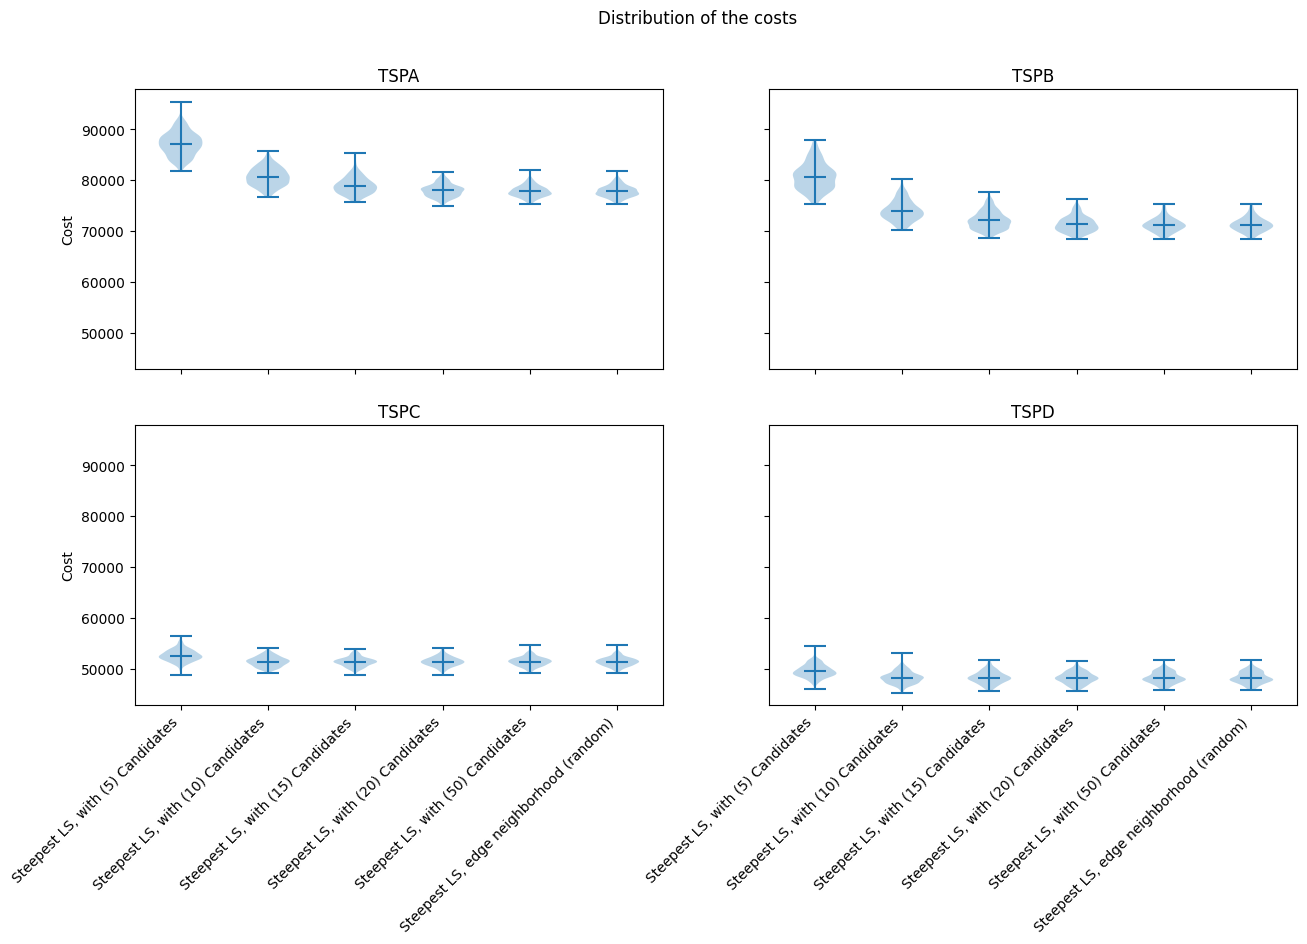

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharey=True)

for idx, instance in enumerate(instances_data.keys()):
    if idx%2 == 0:
        axs[(idx//2)%2][idx%2].set_ylabel('Cost')
    axs[(idx//2)%2][idx%2].set_title(instance)

    axs[(idx//2)%2][idx%2].violinplot(
        [all_costs[instance][solver] for solver in SOLVERS_TO_PLOT.keys()],
        showmeans=True,
    )

    axs[(idx//2)%2][idx%2].set_xticks(range(1, len(SOLVERS_TO_PLOT.keys()) + 1))
    if idx > 1:
        axs[(idx//2)%2][idx%2].set_xticklabels(SOLVERS_TO_PLOT.values(), rotation=45, ha='right')
    else :
        axs[(idx//2)%2][idx%2].set_xticklabels([])

plt.suptitle('Distribution of the costs')
plt.show()

 ### 3.3. Visualizations and statistics of running times for all dataset-algorithm pairs

In [8]:
print("Mean (min-max) of the time [ms]:")

best_times = {
    instance: min(all_times[instance][solver]['mean'] for solver in SOLVERS_TO_PLOT.keys()) / 1000
    for instance in instance_names
}

def apply_style(v: str, best_val: float):
    num = v.split()[0]
    try:
        num = float(num)
    except ValueError:
        return ""
    if round(num) == round(best_val):
        return "font-weight: bold; color: red"
    return ""
    


time_df.T.style.apply(lambda x: [
    apply_style(v, best_times[x.index[i]])
    for i, v in enumerate(x)
], axis = 1)

Mean (min-max) of the time [ms]:


,TSPA,TSPB,TSPC,TSPD
"Steepest LS, with (5) Candidates",4.03 (3.00 - 6.78),4.11 (3.00 - 10.01),4.24 (2.38 - 14.00),4.14 (3.00 - 8.99)
"Steepest LS, with (10) Candidates",5.86 (4.09 - 10.01),5.78 (4.09 - 7.74),6.33 (4.08 - 20.87),6.21 (4.12 - 8.91)
"Steepest LS, with (15) Candidates",7.98 (5.68 - 15.68),8.00 (5.37 - 14.01),7.91 (5.50 - 19.01),8.25 (6.01 - 11.59)
"Steepest LS, with (20) Candidates",10.07 (7.07 - 22.01),9.95 (6.87 - 14.49),10.43 (6.50 - 16.51),11.17 (7.06 - 25.01)
"Steepest LS, with (50) Candidates",24.70 (16.86 - 39.52),25.41 (16.85 - 50.72),26.49 (16.82 - 51.55),25.22 (16.77 - 42.02)
"Steepest LS, edge neighborhood (random)",31.70 (16.06 - 56.81),40.17 (14.02 - 120.04),31.97 (15.02 - 64.05),34.47 (16.26 - 89.33)


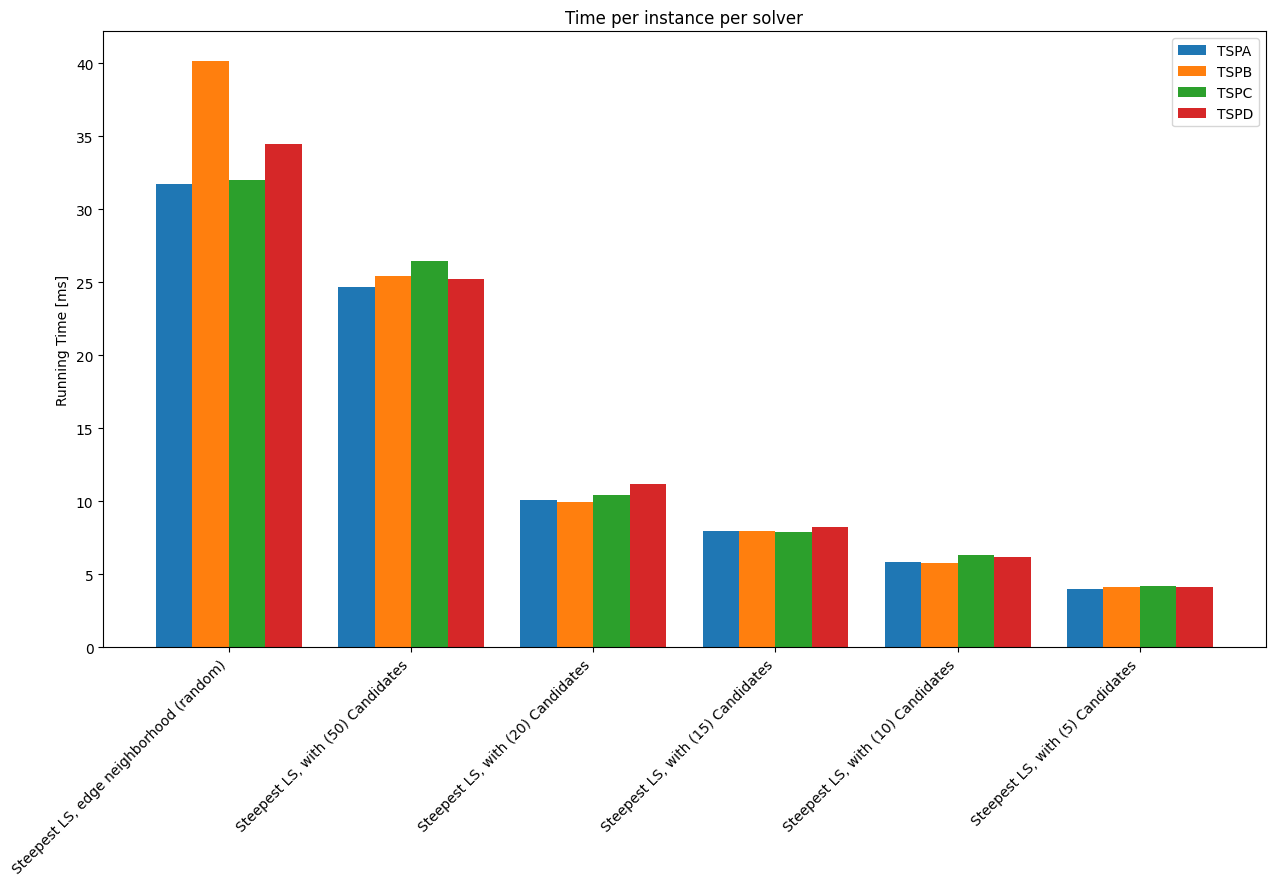

In [9]:
x_range = np.arange(len(SOLVERS_TO_PLOT))
bar_width = 0.8 / len(instances_data.keys())
mean_time_plot_df = mean_time_df.T.sort_values(by="TSPA", ascending=False).T
fig, ax = plt.subplots(figsize=(15, 8), sharey=True)
for idx, instance in enumerate(instances_data.keys()):
     ax.bar(
          x_range + idx * bar_width,
          height=mean_time_plot_df.loc[instance].values,
          width=bar_width,
          label=instance,
     )
ax.set_xticks(x_range + bar_width * (len(instances_data.keys()) - 1) / 2)
ax.set_xticklabels(mean_time_plot_df.columns, rotation=45, ha='right')
plt.title('Time per instance per solver')
plt.ylabel('Running Time [ms]')
plt.legend()
plt.show()


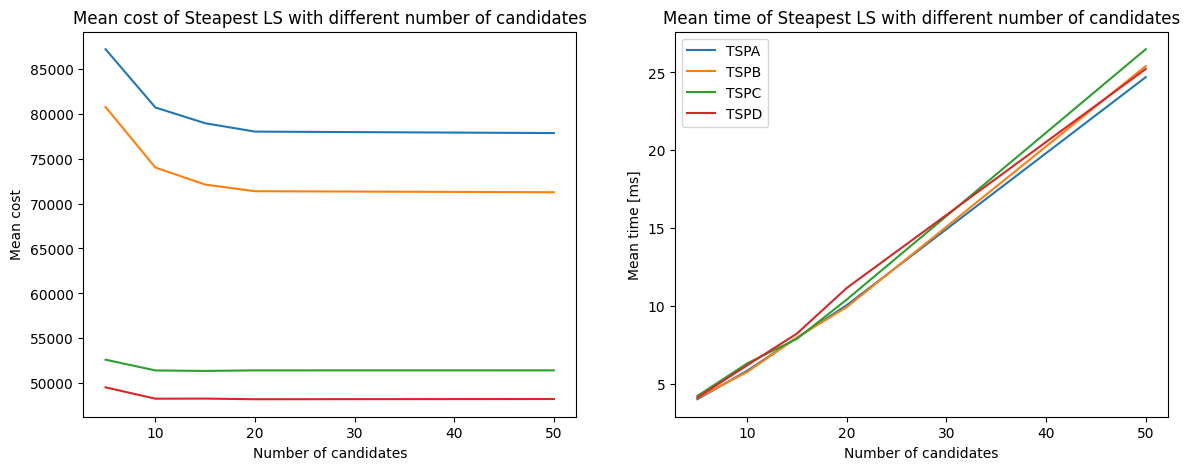

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
N = [5, 10, 15, 20, 50]


for instance in instances_data.keys():
    
    axs[0].plot(
        N,
        [all_stats[instance][f"lsc-{n}-r"]['mean'] for n in N],
        label=instance,
    )
    axs[1].plot(
        N,
        [all_times[instance][f"lsc-{n}-r"]['mean']/1_000 for n in N],
        label=instance,
    )

axs[0].set_title('Mean cost of Steapest LS with different number of candidates')
axs[0].set_xlabel('Number of candidates')
axs[0].set_ylabel('Mean cost')

axs[1].set_title('Mean time of Steapest LS with different number of candidates')
axs[1].set_xlabel('Number of candidates')
axs[1].set_ylabel('Mean time [ms]')

plt.legend()
plt.show()

## 4. Best solutions for all datasets and algorithms

To more easily compare the results, we present the best solutions for each dataset side by side.

The weight of each node is denoted both by its size and color. The bigger and brighter the node, the higher its weight.

### 4.1 New algortithms

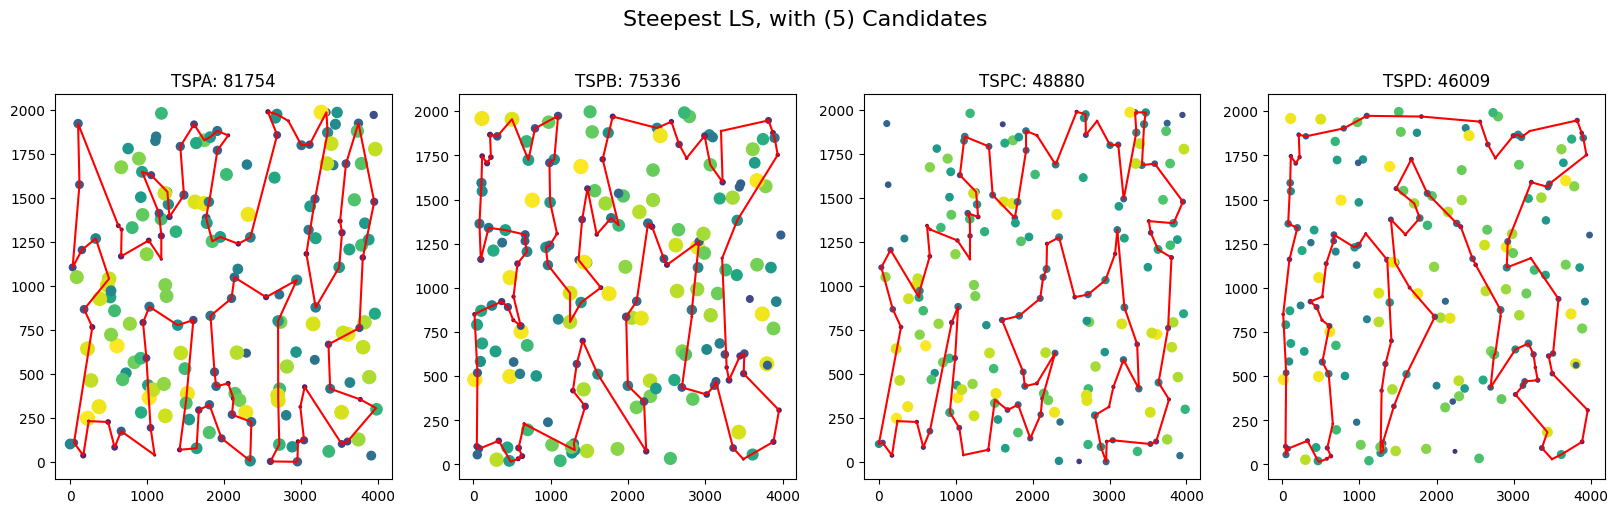

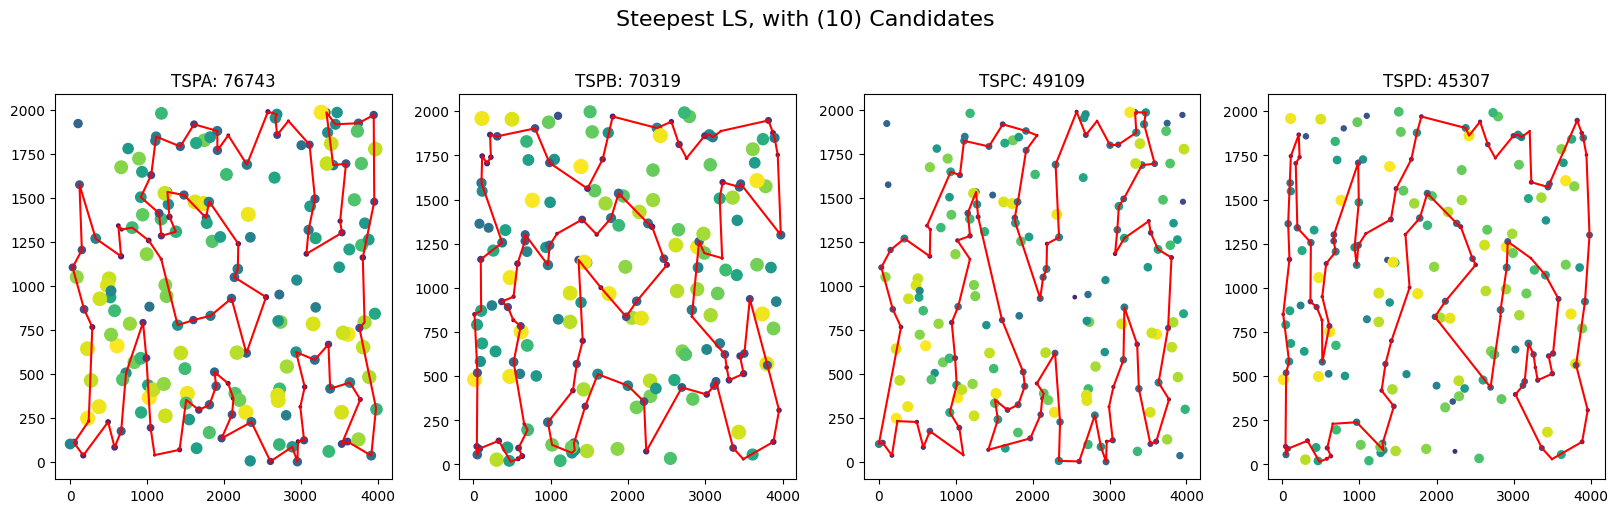

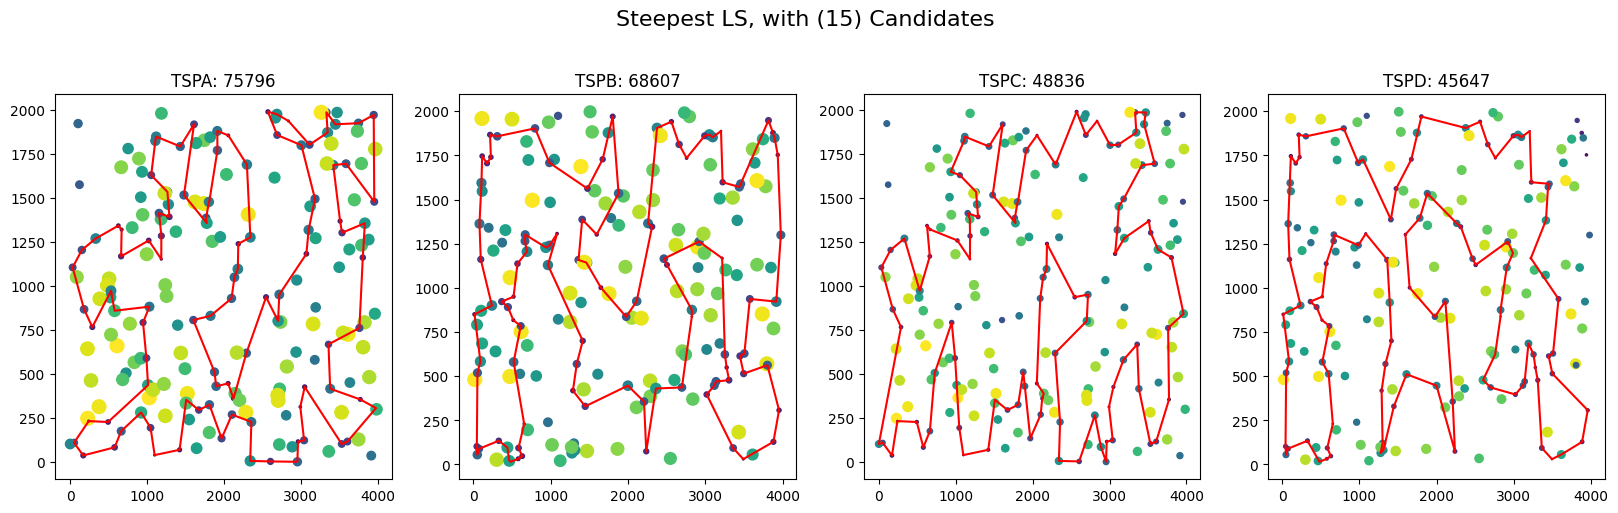

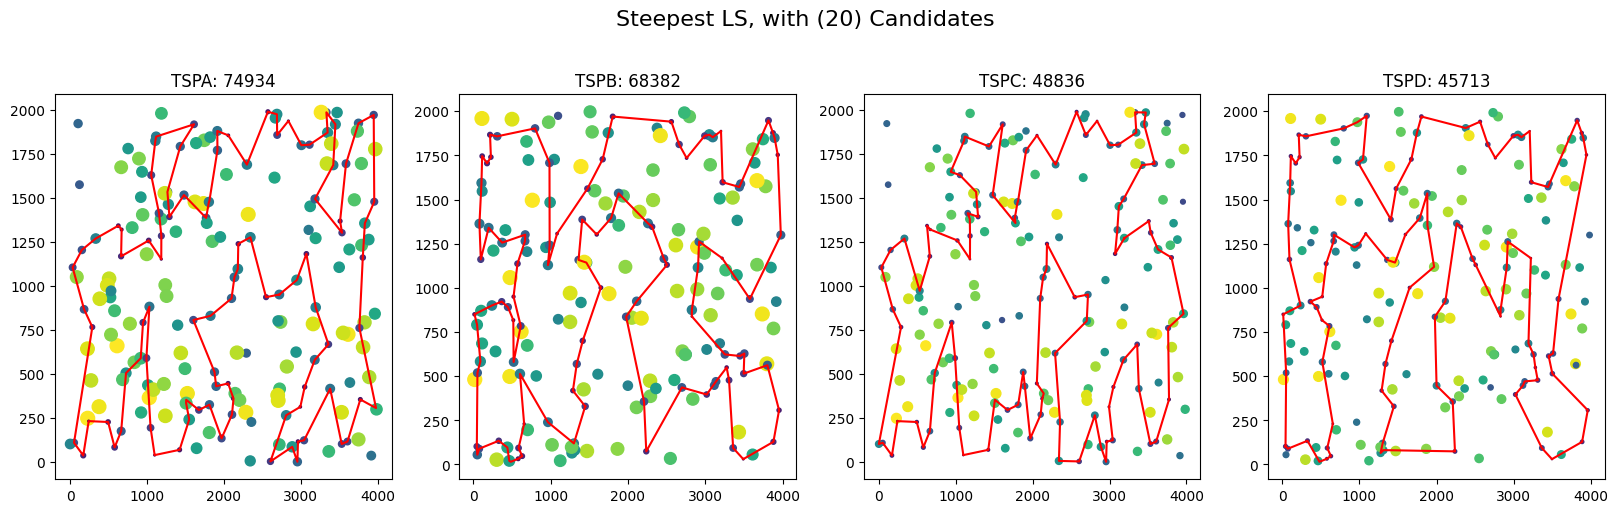

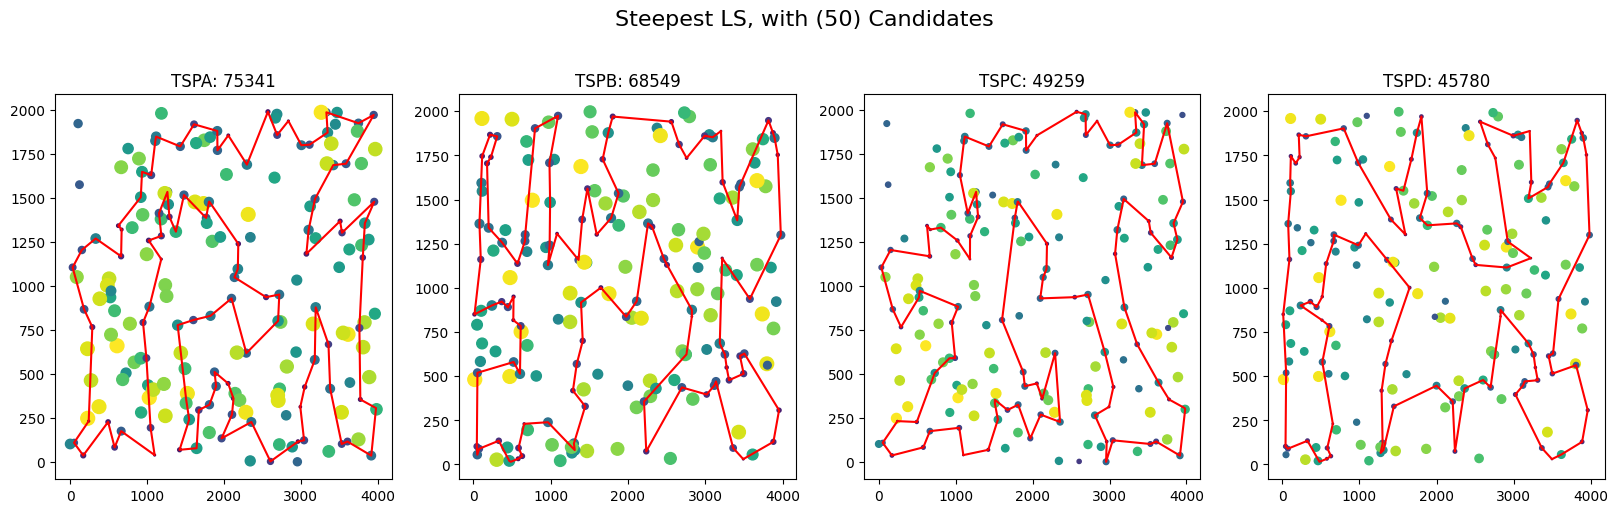

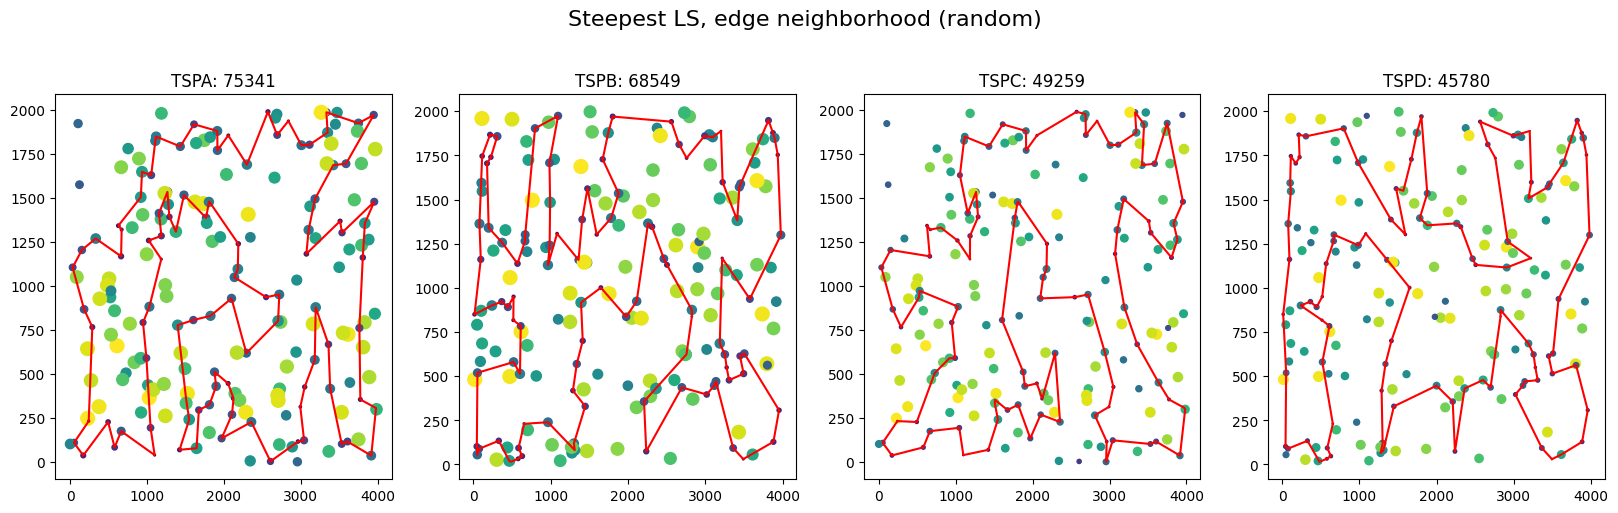

In [11]:
for solver_idx, solver in enumerate(SOLVERS_TO_PLOT.keys()):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for idx, instance in enumerate(instances_data.keys()):
        best_instance_idx = np.argmin(all_costs[instance][solver])
        plot_solution_for_instance(instances_data[instance], all_results[instance][solver][best_instance_idx], axs[idx])
        axs[idx].set_title(f'{instance}: {all_costs[instance][solver][best_instance_idx]:.0f}')
    fig.suptitle(f'{SOLVERS_TO_PLOT[solver]}', fontsize=16, y=1.05)
plt.show()

### 4.2 Best solution for each instance from all algorithms

TSPA
	Solver: Greedy LS, node neighborhood (GH), Total cost: 74244
	 Nodes: [0, 149, 50, 43, 77, 4, 114, 121, 91, 161, 76, 145, 128, 132, 36, 55, 195, 22, 53, 117, 15, 108, 171, 194, 79, 21, 170, 186, 127, 88, 153, 175, 192, 150, 199, 41, 177, 1, 75, 189, 109, 119, 130, 152, 11, 160, 106, 48, 92, 26, 8, 80, 169, 95, 31, 14, 111, 94, 72, 190, 112, 51, 135, 99, 101, 167, 45, 24, 66, 98, 156, 6, 141, 87, 144, 154, 81, 180, 32, 62, 155, 163, 74, 113, 181, 61, 183, 71, 20, 64, 185, 96, 27, 147, 59, 143, 159, 164, 178, 19]

TSPB
	Solver: Steepest LS, both neighborhood (random), Total cost: 67782
	 Nodes: [0, 169, 66, 99, 50, 24, 127, 121, 131, 103, 38, 101, 31, 179, 143, 122, 92, 197, 183, 34, 5, 2, 182, 163, 40, 115, 82, 63, 8, 14, 16, 172, 95, 135, 198, 190, 19, 33, 29, 18, 65, 52, 132, 12, 107, 139, 193, 119, 59, 71, 166, 162, 150, 44, 117, 196, 192, 21, 142, 130, 141, 148, 140, 174, 51, 70, 91, 156, 67, 114, 85, 72, 58, 89, 129, 64, 159, 147, 181, 189, 185, 73, 136, 79, 145, 157, 80, 153

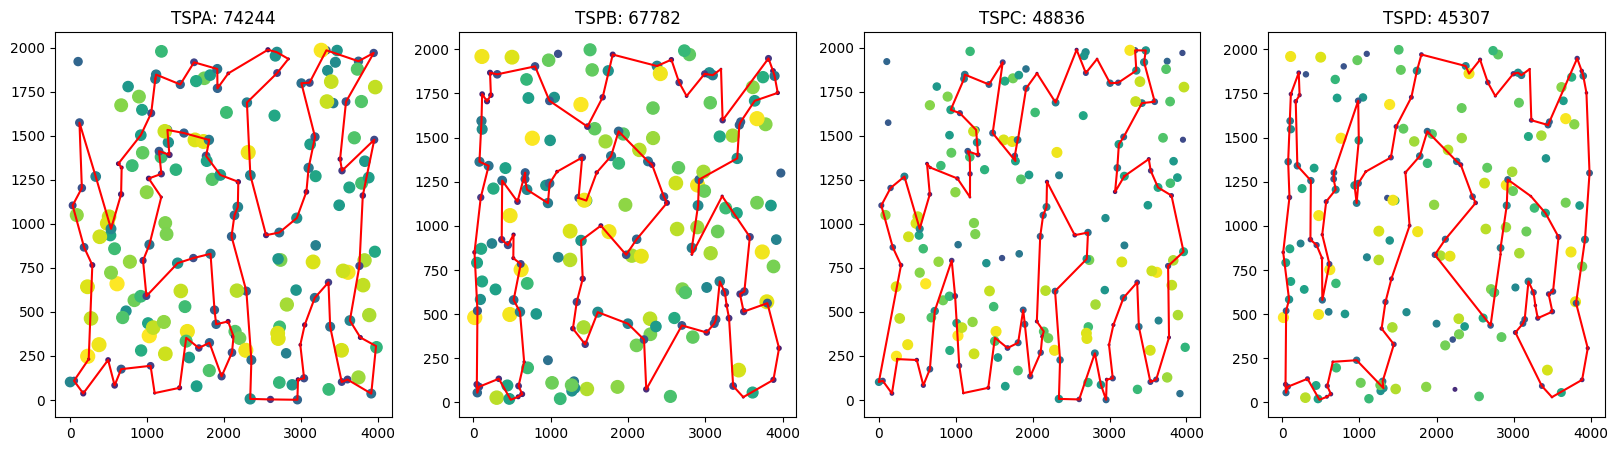

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for idx, instance in enumerate(instances_data.keys()):
    best_cost =  np.inf
    for solver_idx, solver in enumerate(SOLVERS.keys()):
         if best_cost > np.min(all_costs[instance][solver]):
                best_cost = np.min(all_costs[instance][solver])
                best_result = all_results[instance][solver][np.argmin(all_costs[instance][solver])], 
                best_solver = solver
    best_instance_idx = np.argmin(all_costs[instance][best_solver])
    plot_solution_for_instance(instances_data[instance], all_results[instance][best_solver][best_instance_idx], axs[idx])
    axs[idx].set_title(f'{instance}: {all_costs[instance][best_solver][best_instance_idx]:.0f}')
    print(instance)
    print(f'\tSolver: {SOLVERS[best_solver]}, Total cost: {best_cost}')
    zero_index = np.where(best_result[0] == 0)[0][0]
    nodes = list(best_result[0][zero_index:])+list(best_result[0][:zero_index])
    print(f'\t Nodes: {nodes}\n')
plt.show()

## 5. Source Code

[GitHub](https://github.com/Tremirre/ECP)

## 6. Conclusions



Analyzing the results and visualizations, one can come to several conclusions about the algorithms used in the task:
- **Time of running local search algorithm (steepest) with candidate is greatly reduced** in comparison with its version without candidates. This is due to the fact that the number of iterations of the algorithm is reduced, because the algorithm does not have to check all possible neighbours, but only a few of them.
- The running time for steepest local search with *N* candidates grows linearly with *N*. This is due to the fact that the algorithm has to check all *N* candidates, and makes *N* * *|S|* * 2 comparisons per interation, where *|S|* - solution size (constant), so the total time is linearly proportional to *N* (even though the number of iterations may vary).
- The mean cost of the solution found by the algorithm with candidates decreases as the number of candidates *N* increases in a non-linear way - initial decrease is very steep, and then it slows down. Any number of candidates greated than 15 does not seem to have a significant impact on the minimum cost of the solution found by the algorithm, whilst the time of running the algorithm increases significantly.
- Experiments with the number of candidates also yielded some interesting findings: 
    - The number of 5 candidates is too low, i.e. it shows a significant deterioration of results relative to the version with more candidates.  
    - The best results can be seen for the number of candidates between 10 and 20. Increasing this number to 50 can result in worse results (TSPD, TSPC, min in TSPB). 
- The steepest local search algorithm without candidates seems to achieve similar results for its candidate counterparts with *N* larger than 10, although it's worth noting that - counterintuitively - the algorithm with candidates (ergo - with restricted neighborhood) can achieve better results in terms of mean cost:
    - LSC50 for TSPA (77845 < 77856)
    - LSC50 for TSPB (71259 < 71288)
    - LSC15 for TSPC (51370 < 51427)
    - LSC20 for TSPD (48221 < 48253)